# Frequency Conversion-Decoherence-Simulation

$$
\hat{H}=\hbar\left[g(\hat{a}^\dagger\hat{b}\hat{c}^\dagger+\hat{a}\hat{b}^\dagger\hat{c})+E_a(\hat{a}+\hat{a}^\dagger)+E_b(\hat{b}+\hat{b}^\dagger)\right]
$$
where the decay rate is $\kappa_a,\kappa_b,\kappa_c$

$$
\frac{d\langle A_i\rangle}{dt}=\langle\frac{i}{\hbar}[H,A_i]\rangle+\Sigma_n\langle\frac{\kappa_{n}}{2}[2O_n^{\dagger}A_iO_n- O_n^{\dagger}O_nA_i-A_iO_n^{\dagger}O_n]\rangle
$$

Ignoring the coupling for mode A, we get
$$
\frac{d\langle\hat{a}\rangle}{dt}=-iE_a-\frac{\kappa_a}{2}\langle\hat{a}\rangle
$$

Thus $\langle\hat{a}\rangle=-\frac{2iE_a}{\kappa_a}$

Apply the approximation, we get
$$
\hat{H}_{approx}=\hat{H}=\hbar\left[G^*\hat{b}\hat{c}^\dagger+G\hat{b}^\dagger\hat{c}+E_b(\hat{b}+\hat{b}^\dagger)\right]
$$
where $G=-\frac{2igE_a}{\kappa_a}$

## Initial Environment

In [1]:
#import all the things we need
%matplotlib inline
from qutip import*

from scipy import *
from scipy.optimize import curve_fit

import numpy as np

import matplotlib.pyplot as plt

In [2]:
#helper function
def BuildOperator_Approx(g:float):
    Nb=2*max(psi0_l[0],1); Nc=Nb
    psi0=tensor(basis(Nb,psi0_l[0]),basis(Nc,psi0_l[1]))
    b=tensor(destroy(Nb),qeye(Nc))
    c=tensor(qeye(Nb),destroy(Nc))
    H=[[g*b.dag()*c,Cala],[g*b*c.dag(),Calad]]
    c_ops=[]
    operator={'Hamilton':H,'Collapse':c_ops,'Initial_state':psi0,'track':[b.dag()*b,c.dag()*c,b,c]}
    return operator

In [3]:
#helper function
def BuildOperator_Exact(Ea:float,kappa:float,g:float):
    Na=int(max(math.ceil(10*Ea*Ea/(kappa*kappa))+8*Ea/kappa,16)); Nb=2*max(psi0_l[0],1); Nc=Nb
    psi0=tensor(basis(Na,0),basis(Nb,psi0_l[0]),basis(Nc,psi0_l[1]))
    a=tensor(destroy(Na),qeye(Nb),qeye(Nc))
    b=tensor(qeye(Na),destroy(Nb),qeye(Nc))
    c=tensor(qeye(Na),qeye(Nb),destroy(Nc))
    H=g*(a.dag()*b*c.dag()+a*b.dag()*c)+Ea*(a.dag()+a)
    c_ops=[]
    c_ops.append(np.sqrt(kappa)*a)
    operator={'Hamilton':H,'Collapse':c_ops,'Initial_state':psi0,'track':[b.dag()*b,c.dag()*c,b,c,a.dag()*a,a]}
    return operator

In [4]:
def CalDec1(g,kappa,Ea):
    return g*g/kappa
def CalDec2(g,kappa,Ea):
    return g*g*kappa/(2*(kappa*kappa+64*g*g*Ea*Ea/(kappa*kappa)))
def CalShift(g,kappa,Ea):
    na=4*Ea*Ea/(kappa*kappa)
    omega_r=2*g*Ea/kappa
    return -2*g*g*omega_r/(kappa*kappa+16*g*g*na)

In [5]:
#helper function
def BuildOperator_The(g:float,kappa:float,Ea:float):
    Nb=2*max(psi0_l[0],1); Nc=Nb
    psi0=tensor(basis(Nb,psi0_l[0]),basis(Nc,psi0_l[1]))
    b=tensor(destroy(Nb),qeye(Nc))
    c=tensor(qeye(Nb),destroy(Nc))
    dec1=CalDec1(g,kappa,Ea)
    dec2=CalDec2(g,kappa,Ea)
    R=b.dag()*c
    X=R-R.dag()
    Y=R+R.dag()
    Z=R.dag()*R-R*R.dag()
    H=CalShift(g,kappa,Ea)*1j*X
    c_ops=[]
    c_ops.append(np.sqrt(dec1)*X)
    c_ops.append(np.sqrt(dec2)*Y)
    c_ops.append(np.sqrt(dec2)*Z)
    operator={'Hamilton':H,'Collapse':c_ops,'Initial_state':psi0,'track':[b.dag()*b,c.dag()*c,b*c.dag(),b.dag()*c]}
    return operator

In [6]:
def Cala(t,args):
    return -2j*args['E']/args['kappa']*(1-np.exp(-args['kappa']*t/2))

In [7]:
def Calad(t,args):
    return 2j*args['E']/args['kappa']*(1-np.exp(-args['kappa']*t/2))

## Complete Model and Analysis

### Dynamics

In [8]:
psi0_l=[1,0]
Ea=20
kappa_a=20
g=0.5
op=BuildOperator_Exact(Ea,kappa_a,g)
tlist=np.linspace(0,40,2000)

In [9]:
print("gamma_1="+str(CalDec1(g,kappa_a,Ea)))
print("gamma_2="+str(CalDec2(g,kappa_a,Ea)))
print("Shift="+str(-2*CalShift(g,kappa_a,Ea)))

gamma_1=0.0125
gamma_2=0.006009615384615385
Shift=0.002403846153846154


In [10]:
output=mesolve(op['Hamilton'],op['Initial_state'],tlist,op['Collapse'],op['track'])

Text(0, 0.5, '$N_a$')

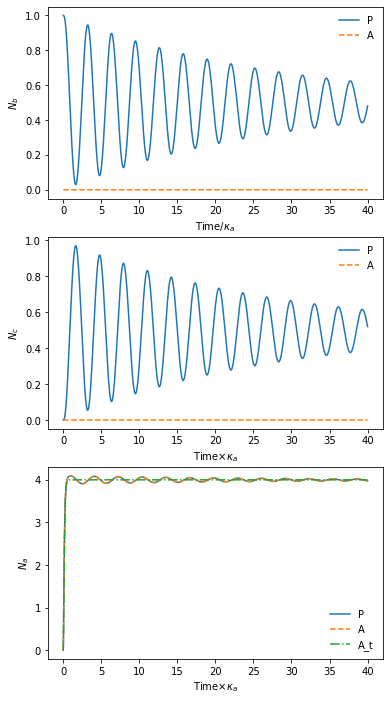

In [11]:
fig, axes = plt.subplots(3,1,figsize=(6,12))

axes[0].plot(tlist, output.expect[0],label="P")
axes[1].plot(tlist, output.expect[1],label="P")
axes[2].plot(tlist, output.expect[4],label="P")
axes[0].plot(tlist, np.real(np.conj(output.expect[2])*output.expect[2]),linestyle='--',label="A")
axes[1].plot(tlist, np.real(np.conj(output.expect[3])*output.expect[3]),linestyle='--',label="A")
axes[2].plot(tlist, np.real(np.conj(output.expect[5])*output.expect[5]),linestyle='--',label="A")
axes[2].plot(tlist, np.real(Cala(tlist,args={'E':Ea,'kappa':kappa_a})*Calad(tlist,args={'E':Ea,'kappa':kappa_a})),linestyle='-.',label='A_t')

axes[0].legend(loc=0,ncol=1,frameon=False)
axes[1].legend(loc=0,ncol=1,frameon=False)
axes[2].legend(loc=0,ncol=1,frameon=False)

axes[0].set_xlabel('Time/'+r'$\kappa_a$')
axes[0].set_ylabel(r'$N_b$')

axes[1].set_xlabel('Time'+r'$\times\kappa_a$')
axes[1].set_ylabel(r'$N_c$')

axes[2].set_xlabel('Time'+r'$\times\kappa_a$')
axes[2].set_ylabel(r'$N_a$')

### Envelop

In [12]:
photon_b=output.expect[0]
Envelop_b=[]
Envelop_t=[]
Envelop_b.append(photon_b[0])
Envelop_t.append(tlist[0])
for j in range(1,np.size(tlist)-1):
    if (photon_b[j]>photon_b[j-1]) and (photon_b[j]>photon_b[j+1]):
        Envelop_b.append(photon_b[j])
        Envelop_t.append(tlist[j])
Envelop_b=np.asarray(Envelop_b)
Envelop_t=np.asarray(Envelop_t)

In [13]:
def func(x,gamma):
    return 0.5+0.5*np.exp(gamma*x)
def func2(x,T,T0):
    return T*x+T0

In [14]:
popt, pcov = curve_fit(func,Envelop_t ,Envelop_b,bounds=(-1,0))
popt2, pcov2=curve_fit(func2,range(1,np.size(Envelop_t)) ,Envelop_t[1:])

In [15]:
print('Dephasing Rate= ',-1*popt[0])
omega_r=2*np.pi/popt2[0]
omega_i=4*g*Ea/kappa_a
shift_r=omega_r-omega_i
print('Shift= ',shift_r)

Dephasing Rate=  0.03677312579740925
Shift=  0.0021095779197031206


Text(0, 0.5, '$N_b$')

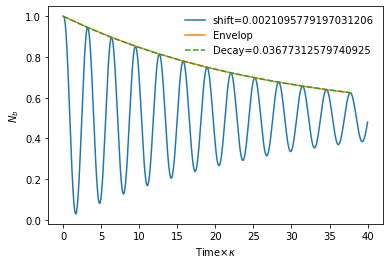

In [16]:
fig, axes = plt.subplots(1,1,figsize=(6,4))

axes.plot(tlist, output.expect[0],label="shift="+str(shift_r))
axes.plot(Envelop_t,Envelop_b,label="Envelop")
axes.plot(Envelop_t,func(Envelop_t,*popt),linestyle='--',label="Decay="+str(np.abs(popt[0])))

axes.legend(loc=0,ncol=1,frameon=False)

axes.set_xlabel('Time'+r'$\times\kappa$')
axes.set_ylabel(r'$N_b$')